In [120]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def pacejka(params, SA):
    '''
    Pacejka function:
        Input:  - Tire parameters (B, C, D, E, H, V)
                - Slip angles
        Output: - Grip coefficient
    '''
    B = params[0]
    C = params[1]
    D = params[2]
    E = params[3]
    H = params[4]
    V = params[5]

    mu_y = D * np.sin(C * np.arctan(B * (SA + H) - E * (B * (SA + H) + np.arctan(B * (SA + H))))) + V
    return np.array(mu_y)

In [122]:
tau = 0.01
params = [30, 1.5, -1.4, 0, 0, 0]

x0 = np.random.normal(loc=0.0, scale=tau)
mu0 = pacejka(params, x0)


In [123]:
T = 25.0
dT = 0.01
n = int(T / dT) - 1
x_history = np.zeros(n)
mu_history = np.zeros(n)

for i in range(n):
    x1 = np.random.normal(loc=x0, scale=tau)
    mu1 = pacejka(params, x1)
    
    if mu1 < mu0:
        x0 = x1 
        mu0 = mu1
    else:
        alpha = min([1, np.exp(-abs(mu1 - mu0)/T)])
        if alpha > np.random.uniform():
            x0 = x1

    x_history[i] = x0
    mu_history[i] = mu0

    T -= dT

        


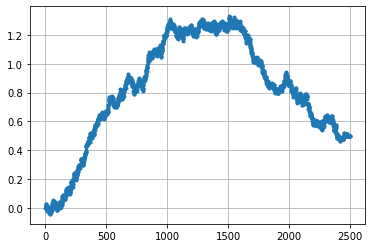

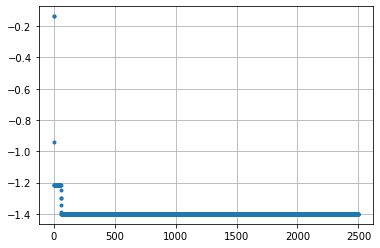

In [124]:
plt.figure()
plt.plot(x_history, '.')
plt.grid()

plt.figure()
plt.plot(mu_history, '.')
plt.grid()

In [125]:
print(x0)
print(mu0)
print(pacejka(params, x0))

0.4975243129619072
-1.3999698271574859
-1.0841419086840354


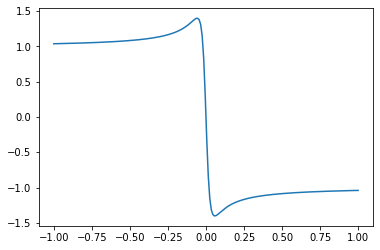

In [126]:
xx = np.linspace(-1.0, 1.0, 200)
plt.plot(xx, pacejka(params, xx))

In [1]:
import time

from plotter import Plotter
from optimizer import Optimizer
import matplotlib.pyplot as plt

In [2]:

logfile = 'Log_20200823_162812_xintong2.csv'

GE = Optimizer(logfile)  # Init GE with logdata
t = time.time()
GE.run_sim_annealing() 

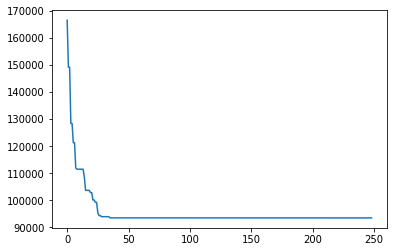

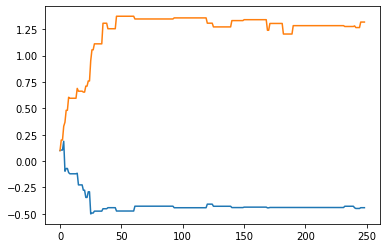

In [3]:
plt.figure()
plt.plot(GE.history_cost)

plt.figure()
plt.plot(GE.history_T_slope_front)
plt.plot(GE.history_T_slope_rear)

In [5]:
plotter= Plotter(GE)

-0.44137835044098345
1.3173294303794938


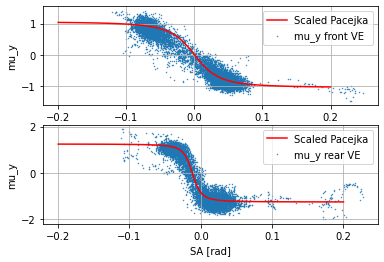

In [6]:
plotter.plot_pacejka()
print(GE.T_slope_front_opt)
print(GE.T_slope_rear_opt)

In [12]:
import torch
import numpy as np

import time

from plotter import Plotter
from optimizer import Optimizer
import matplotlib.pyplot as plt

In [17]:
def pacejka_torch(params, SA, T_slope):
    '''
    Pacejka function:
        Input:  - Tire parameters (B, C, D, E, H, V)
                - Slip angles
        Output: - Grip coefficient
    '''
    B = params[0] * T_slope
    C = params[1]
    D = params[2]
    E = params[3]
    H = params[4]
    V = params[5]

    mu_y = D * torch.sin(C * torch.atan(B * (SA + H) - E * (B * (SA + H) + torch.atan(B * (SA + H))))) + V
    return mu_y

In [24]:
logfile = 'Log_20200823_162812_xintong2.csv'
GE = Optimizer(logfile)  # Init GE with logdata

def gradient(T_slope):
    
    params_front = [GE.tire.Bf, GE.tire.Cf, GE.tire.Df, GE.tire.Ef, GE.tire.Hf, GE.tire.Vf]
    params_rear = [GE.tire.Br, GE.tire.Cr, GE.tire.Dr, GE.tire.Er, GE.tire.Hr, GE.tire.Vr]

    # Get constraints vector representing bicycle model
    b_ax, b_ay, b_ddyaw = GE.get_constraint_vectors()

    F_fy = pacejka_torch(params_front, torch.from_numpy(GE.VE.SA_f), T_slope[0])
    F_ry = pacejka_torch(params_rear, torch.from_numpy(GE.VE.SA_r), T_slope[1])

    ax = (torch.from_numpy(b_ax) - F_fy * torch.sin(torch.from_numpy(GE.VE.delta))) / GE.car.m 
    ay = (torch.from_numpy(b_ay) + F_ry + F_fy * torch.cos(torch.from_numpy(GE.VE.delta))) / GE.car.m

    cost = torch.linalg.norm(ax - torch.from_numpy(GE.VE.ax))**2 + torch.linalg.norm(ay - torch.from_numpy(GE.VE.ay))**2

    cost.backward()
    
    print(T_slope.grad)

In [25]:
T_slope = torch.tensor([0.1, 0.1], requires_grad=True)

gradient(T_slope)

tensor([-8295.6885, -5468.7769])
